In [7]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBClassifier, XGBRegressor
from imblearn.over_sampling import SMOTE
import joblib
np.random.seed(42)
warnings.filterwarnings("ignore")


In [9]:
DATA_PATH = "data/merged_aqi_data.csv"
df = pd.read_csv(DATA_PATH)
df["datetime"] = pd.to_datetime(df["datetime"])
df["year"] = df["datetime"].dt.year
df["month"] = df["datetime"].dt.month
df["day"] = df["datetime"].dt.day
df["hour"] = df["datetime"].dt.hour
df = df.reset_index(drop=True)
df = df.rename(columns={"pm2_5":"pm2_5","pm10":"pm10"})
df = df.loc[:, ["datetime","ow_aqi","co","no","no2","o3","so2","pm2_5","pm10","nh3","year","month","day","hour"]]
df = df.dropna().reset_index(drop=True)
df["ow_aqi_orig"] = df["ow_aqi"].astype(float)
df["ow_aqi_round"] = df["ow_aqi_orig"].round().astype(int)
df = df[df["ow_aqi_round"].between(1,5)]
df = df.reset_index(drop=True)
X = df[["co","no","no2","o3","so2","pm2_5","pm10","nh3","year","month","day","hour"]].copy()
y_class = df["ow_aqi_round"].copy()
y_reg = df["ow_aqi_orig"].copy()
class_map = {1:0,2:1,3:2,4:3,5:4}
inv_class_map = {v:k for k,v in class_map.items()}
y = y_class.map(class_map)


In [10]:
X_train, X_test, y_train, y_test, y_reg_train, y_reg_test = train_test_split(
    X, y, y_reg, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [11]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_scaled, y_train)
unique_before = y_train.value_counts().to_dict()
unique_after = pd.Series(y_res).value_counts().to_dict()
print("Before SMOTE:", unique_before)
print("After SMOTE:", unique_after)


Before SMOTE: {2: 2118, 4: 1418, 3: 1241, 1: 654, 0: 305}
After SMOTE: {2: 2118, 3: 2118, 0: 2118, 4: 2118, 1: 2118}


In [12]:
baseline_models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Naive Bayes": GaussianNB()
}
importances = {}
baseline_results = []
for name, model in baseline_models.items():
    model.fit(X_res, y_res)
    preds = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average="macro")
    baseline_results.append([name, acc, f1])
baseline_df = pd.DataFrame(baseline_results, columns=["Model","Accuracy","F1-score"]).sort_values("Accuracy", ascending=False)
baseline_df


,Model,Accuracy,F1-score
0,Decision Tree,0.997211,0.992582
2,Logistic Regression,0.924686,0.910510
1,KNN,0.890516,0.879421
3,Naive Bayes,0.683403,0.656759


In [13]:
adv_models = {
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, random_state=42)
}
try:
    from lightgbm import LGBMClassifier
    adv_models["LightGBM"] = LGBMClassifier(n_estimators=200, random_state=42)
except Exception:
    print("LightGBM not available, skipping")
adv_models["XGBoost"] = XGBClassifier(n_estimators=200, random_state=42, eval_metric="mlogloss", use_label_encoder=False)
adv_results = []
for name, model in adv_models.items():
    model.fit(X_res, y_res)
    preds = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average="macro")
    adv_results.append([name, acc, f1])
adv_df = pd.DataFrame(adv_results, columns=["Model","Accuracy","F1-score"]).sort_values("Accuracy", ascending=False)
adv_df


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2808
[LightGBM] [Info] Number of data points in the train set: 10590, number of used features: 12
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

,Model,Accuracy,F1-score
1,Gradient Boosting,0.996513,0.991978
0,Random Forest,0.995119,0.991217
2,LightGBM,0.992329,0.991099
3,XGBoost,0.987448,0.980457


In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_summary = []
for name, model in adv_models.items():
    try:
        scores = cross_val_score(model, X_res, y_res, cv=cv, scoring="accuracy", n_jobs=-1)
        cv_summary.append([name, scores.mean(), scores.std()])
    except Exception as e:
        cv_summary.append([name, np.nan, np.nan])
cv_df = pd.DataFrame(cv_summary, columns=["Model","Mean Accuracy","Std Accuracy"]).sort_values("Mean Accuracy", ascending=False)
cv_df


,Model,Mean Accuracy,Std Accuracy
1,Gradient Boosting,0.998678,0.000916
0,Random Forest,0.998111,0.000790
2,LightGBM,0.996506,0.001141
3,XGBoost,0.994806,0.001302


In [18]:
def tune_rf(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5)
    }
    model = RandomForestClassifier(**params, random_state=42, n_jobs=-1)
    scores = cross_val_score(model, X_res, y_res, cv=3, scoring="accuracy", n_jobs=-1)
    return scores.mean()

study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(tune_rf, n_trials=30, show_progress_bar=False)
best_rf_params = study_rf.best_params
print("Best RF params:", best_rf_params)


def tune_xgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0)
    }
    model = XGBClassifier(
        **params,
        random_state=42,
        use_label_encoder=False,
        eval_metric="mlogloss"
    )
    scores = cross_val_score(model, X_res, y_res, cv=3, scoring="accuracy", n_jobs=-1)
    return scores.mean()

study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(tune_xgb, n_trials=30, show_progress_bar=False)
best_xgb_params = study_xgb.best_params
print("Best XGB params:", best_xgb_params)

[I 2025-11-05 19:04:24,835] A new study created in memory with name: no-name-06afcdf1-3fb4-4c51-b50c-39f7dd780a04
[I 2025-11-05 19:04:26,727] Trial 0 finished with value: 0.9963172804532577 and parameters: {'n_estimators': 163, 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9963172804532577.
[I 2025-11-05 19:04:28,858] Trial 1 finished with value: 0.9966949952785646 and parameters: {'n_estimators': 189, 'max_depth': 13, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9966949952785646.
[I 2025-11-05 19:04:32,764] Trial 2 finished with value: 0.9796033994334278 and parameters: {'n_estimators': 473, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.9966949952785646.
[I 2025-11-05 19:04:33,861] Trial 3 finished with value: 0.996600566572238 and parameters: {'n_estimators': 86, 'max_depth': 21, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 1 with value: 0

Best RF params: {'n_estimators': 224, 'max_depth': 22, 'min_samples_split': 8, 'min_samples_leaf': 1}


[I 2025-11-05 19:05:59,170] Trial 0 finished with value: 0.9926345609065156 and parameters: {'n_estimators': 125, 'max_depth': 12, 'learning_rate': 0.012456771106045464, 'subsample': 0.7988232006200761, 'colsample_bytree': 0.5635443630910058}. Best is trial 0 with value: 0.9926345609065156.
[I 2025-11-05 19:06:04,629] Trial 1 finished with value: 0.9932955618508026 and parameters: {'n_estimators': 440, 'max_depth': 8, 'learning_rate': 0.2023978397707516, 'subsample': 0.7411170045263658, 'colsample_bytree': 0.5185721006002042}. Best is trial 1 with value: 0.9932955618508026.
[I 2025-11-05 19:06:07,986] Trial 2 finished with value: 0.9941454202077432 and parameters: {'n_estimators': 172, 'max_depth': 11, 'learning_rate': 0.040353490372998194, 'subsample': 0.6376991389238875, 'colsample_bytree': 0.9352179193650504}. Best is trial 2 with value: 0.9941454202077432.
[I 2025-11-05 19:06:16,698] Trial 3 finished with value: 0.9936732766761095 and parameters: {'n_estimators': 409, 'max_depth': 

Best XGB params: {'n_estimators': 180, 'max_depth': 12, 'learning_rate': 0.057678322166759985, 'subsample': 0.6991447733928631, 'colsample_bytree': 0.9526883734211227}


In [21]:
if best_xgb_params:
    final_clf = XGBClassifier(**best_xgb_params, random_state=42, use_label_encoder=False, eval_metric="mlogloss")
elif best_rf_params:
    final_clf = RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1)
else:
    final_clf = GradientBoostingClassifier(n_estimators=200, random_state=42)
final_clf.fit(X_res, y_res)
y_pred_clf = final_clf.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred_clf)
f1 = f1_score(y_test, y_pred_clf, average="macro")
print("Final Classifier accuracy", acc)
print(classification_report(y_test, y_pred_clf, target_names=["1","2","3","4","5"]))
cm = confusion_matrix(y_test, y_pred_clf)
print("Confusion matrix:\n", cm)
joblib.dump(final_clf, "notebook/models/final_classifier.pkl")
joblib.dump(scaler, "notebook/models/scaler.pkl")

Final Classifier accuracy 0.9881450488145049
              precision    recall  f1-score   support

           1       0.97      0.96      0.97        76
           2       0.96      0.96      0.96       163
           3       0.99      0.99      0.99       530
           4       0.98      1.00      0.99       310
           5       1.00      1.00      1.00       355

    accuracy                           0.99      1434
   macro avg       0.98      0.98      0.98      1434
weighted avg       0.99      0.99      0.99      1434

Confusion matrix:
 [[ 73   3   0   0   0]
 [  2 157   4   0   0]
 [  0   3 523   4   0]
 [  0   0   0 310   0]
 [  0   0   0   1 354]]


['notebook/models/scaler.pkl']

In [23]:
reg_scaler = StandardScaler()
X_train_reg = reg_scaler.fit_transform(X_train)
X_test_reg = reg_scaler.transform(X_test)
reg_model = GradientBoostingRegressor(n_estimators=300, random_state=42)
reg_model.fit(X_train_reg, y_reg_train)
y_pred_reg = reg_model.predict(X_test_reg)
print("MAE:", mean_absolute_error(y_reg_test, y_pred_reg))
print("RMSE:", mean_squared_error(y_reg_test, y_pred_reg))
print("R2:", r2_score(y_reg_test, y_pred_reg))
joblib.dump(reg_model, "notebook/models/final_regressor.pkl")
joblib.dump(reg_scaler, "notebook/models/reg_scaler.pkl")


MAE: 0.012147679352001705
RMSE: 0.004464282006061524
R2: 0.9965403254192311


['notebook/models/reg_scaler.pkl']

In [24]:
def map_class_to_label(pred_class):
    mapping = {0:"Good",1:"Satisfactory",2:"Moderate",3:"Poor",4:"Very Poor"}
    return mapping[int(pred_class)]

def estimate_range_from_reg(aqi_value):
    if aqi_value <= 50: return "Good (0-50)"
    if aqi_value <= 100: return "Satisfactory (51-100)"
    if aqi_value <= 200: return "Moderate (101-200)"
    if aqi_value <= 300: return "Poor (201-300)"
    return "Very Poor (>300)"

def predict_sample(df_row):
    features = df_row[["co","no","no2","o3","so2","pm2_5","pm10","nh3","year","month","day","hour"]].values.reshape(1,-1)
    features_scaled = scaler.transform(features)
    class_pred = final_clf.predict(features_scaled)[0]
    class_proba = final_clf.predict_proba(features_scaled)[0] if hasattr(final_clf, "predict_proba") else None
    reg_features = reg_scaler.transform(features)
    reg_pred = reg_model.predict(reg_features)[0]
    return {
        "predicted_class_numeric": int(inv_class_map[int(class_pred)]),
        "predicted_class_label": map_class_to_label(class_pred),
        "class_proba": class_proba.tolist() if class_proba is not None else None,
        "predicted_aqi": float(reg_pred),
        "aqi_range_estimate": estimate_range_from_reg(reg_pred)
    }
sample_out = predict_sample(df.iloc[0])
sample_out


{'predicted_class_numeric': 3,
 'predicted_class_label': 'Moderate',
 'class_proba': [7.95198866399005e-05,
  9.467133349971846e-05,
  0.9995701909065247,
  0.00014537597598973662,
  0.00011025700950995088],
 'predicted_aqi': 2.9923094934950214,
 'aqi_range_estimate': 'Good (0-50)'}

In [25]:
X_test_df = X_test.reset_index(drop=True)
preds_class = final_clf.predict(X_test_scaled)
probs = final_clf.predict_proba(X_test_scaled) if hasattr(final_clf, "predict_proba") else None
preds_reg = reg_model.predict(X_test_reg)
out = X_test_df.copy()
out["pred_class_num"] = [inv_class_map[int(x)] for x in preds_class]
out["pred_class_label"] = [map_class_to_label(x) for x in preds_class]
if probs is not None:
    for i in range(probs.shape[1]):
        out[f"prob_class_{i+1}"] = probs[:,i]
out["pred_aqi_continuous"] = preds_reg
out["pred_aqi_range"] = out["pred_aqi_continuous"].apply(estimate_range_from_reg)
os.makedirs("notebook/output", exist_ok=True)
out.to_csv("notebook/output/test_predictions_with_estimates.csv", index=False)
out.head(10)


,co,no,no2,o3,so2,pm2_5,pm10,nh3,year,month,...,hour,pred_class_num,pred_class_label,prob_class_1,prob_class_2,prob_class_3,prob_class_4,prob_class_5,pred_aqi_continuous,pred_aqi_range
0,91.19,0.00,0.05,44.71,0.06,5.95,22.46,0.00,2025,9,...,18,2,Satisfactory,0.000392,0.999088,0.000209,0.000192,0.000119,2.007422,Good (0-50)
1,620.84,0.00,11.82,95.84,5.54,37.82,53.38,3.45,2025,1,...,0,3,Moderate,0.000050,0.000059,0.999708,0.000115,0.000068,3.002763,Good (0-50)
2,83.16,0.00,0.06,45.78,0.35,36.08,149.44,0.00,2025,6,...,13,4,Poor,0.000047,0.000057,0.000099,0.999738,0.000059,4.001448,Good (0-50)
3,547.41,0.00,19.02,65.09,5.19,59.24,200.58,5.00,2024,10,...,17,5,Very Poor,0.000309,0.000354,0.000582,0.029316,0.969439,4.979257,Good (0-50)
4,767.71,1.10,17.99,173.09,28.13,68.52,92.97,4.69,2025,1,...,11,4,Poor,0.000712,0.000843,0.003170,0.892371,0.102904,4.549841,Good (0-50)
5,554.08,1.51,15.25,77.96,4.17,29.06,73.07,3.99,2025,3,...,4,3,Moderate,0.000067,0.000080,0.999590,0.000174,0.000090,3.004981,Good (0-50)
6,2777.10,22.13,82.25,23.60,28.61,125.78,183.65,38.50,2024,12,...,4,5,Very Poor,0.000053,0.000056,0.000098,0.000203,0.999591,4.998993,Good (0-50)
7,141.05,0.01,0.12,99.57,1.00,40.11,87.63,0.00,2025,10,...,10,3,Moderate,0.000063,0.000074,0.999400,0.000327,0.000135,2.995569,Good (0-50)
8,567.44,2.51,14.39,82.25,4.47,27.83,71.29,4.18,2025,3,...,5,3,Moderate,0.000055,0.000064,0.999687,0.000120,0.000074,2.999355,Good (0-50)
9,6408.69,5.14,159.03,572.20,49.59,701.07,778.56,52.69,2025,3,...,9,5,Very Poor,0.000041,0.000049,0.000077,0.000114,0.999719,4.997630,Good (0-50)


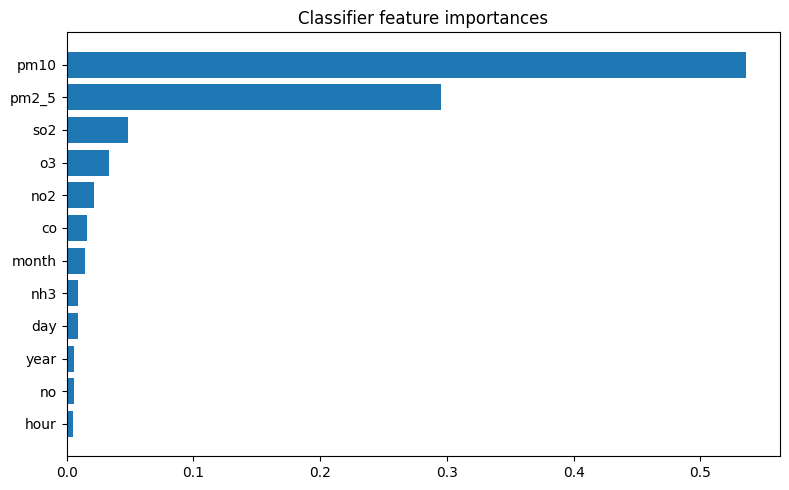

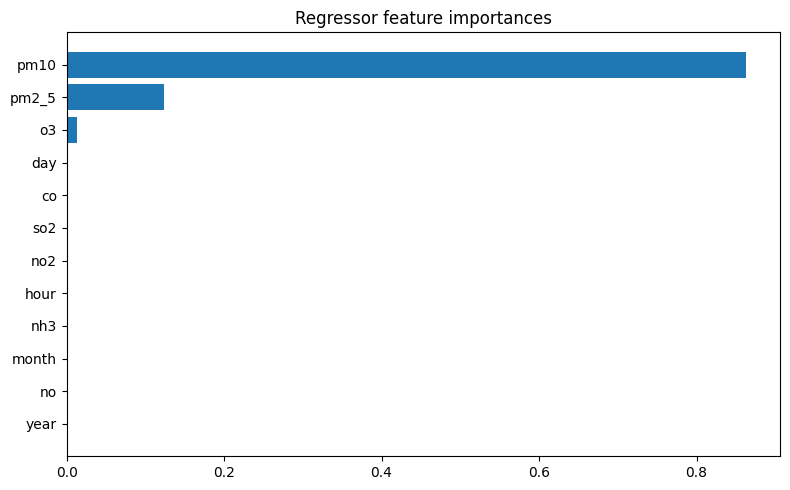

 97%|=================== | 973/1000 [00:21<00:00]       

SHAP not available or failed, feature importances saved instead.


In [31]:
try:
    import matplotlib.pyplot as plt
    importances_clf = None
    if hasattr(final_clf, "feature_importances_"):
        importances_clf = final_clf.feature_importances_
    elif hasattr(final_clf, "coef_"):
        importances_clf = np.abs(final_clf.coef_).ravel()
    if importances_clf is not None:
        feat_names = ["co","no","no2","o3","so2","pm2_5","pm10","nh3","year","month","day","hour"]
        imp_df = pd.DataFrame({"feature":feat_names,"importance":importances_clf}).sort_values("importance", ascending=False)
        plt.figure(figsize=(8,5))
        plt.barh(imp_df["feature"], imp_df["importance"])
        plt.gca().invert_yaxis()
        plt.title("Classifier feature importances")
        plt.tight_layout()
        plt.savefig("notebook/output/classifier_feature_importance.png")
        plt.show()
    reg_imp = None
    if hasattr(reg_model, "feature_importances_"):
        reg_imp = reg_model.feature_importances_
    if reg_imp is not None:
        feat_names = ["co","no","no2","o3","so2","pm2_5","pm10","nh3","year","month","day","hour"]
        imp_df_r = pd.DataFrame({"feature":feat_names,"importance":reg_imp}).sort_values("importance", ascending=False)
        plt.figure(figsize=(8,5))
        plt.barh(imp_df_r["feature"], imp_df_r["importance"])
        plt.gca().invert_yaxis()
        plt.title("Regressor feature importances")
        plt.tight_layout()
        plt.savefig("notebook/output/regressor_feature_importance.png")
        plt.show()
    try:
        import shap
        explainer = shap.Explainer(final_clf, X_res)
        shap_values = explainer(X_test_scaled[:200])
        shap.plots.beeswarm(shap_values)
    except Exception:
        print("SHAP not available or failed, feature importances saved instead.")
except Exception as e:
    print("Plotting failed:", e)


In [29]:
results_summary = {
    "baseline": baseline_df,
    "advanced": adv_df,
    "cv": cv_df,
    "final_classifier_accuracy": acc,
    "final_classifier_f1_macro": f1,
    "regression_mae": mean_absolute_error(y_reg_test, y_pred_reg),
    "regression_rmse": mean_squared_error(y_reg_test, y_pred_reg),
    "regression_r2": r2_score(y_reg_test, y_pred_reg)
}
os.makedirs("notebook/models", exist_ok=True)
joblib.dump(results_summary, "notebook/models/results_summary.pkl")
pd.DataFrame([results_summary]).to_csv("notebook/output/results_summary_flat.csv", index=False)
